# Relation Extraction

## Set variables

In [1]:
logdir = './logs/BiodivBERT' # for tensorboard
MODEL_PATH = 'NoYo25/BiodivBERT'

batch_size = 16
num_train_epochs = 4

Select specific GPU

In [2]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '1'

## Install and import necessary libraries

In [3]:
# ! pip install transformers
# ! pip install pandas
# ! pip install scikit-learn
# ! pip install numpy
# ! pip install torch
# ! pip install optuna
# ! pip install -q tb-nightly
# ! pip install tensorboard
# ! pip install tensorflow

In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import shutil
import dill

## Dataset Preprocessing


Dataset config file

In [5]:
root_data_dir = "../Datasets/RE_MultiClass/BiodivRE_MultiClass"


### GAD Loading

Data loading utils

In [6]:
def loadData(csv_file_path, header=None, index_col=None):
  dataset_path = os.path.join(root_data_dir, csv_file_path)
  data = pd.read_csv(dataset_path, encoding="latin1", sep=',', header=header, index_col=index_col, names=['Label', 'Sentence'])
  # data = data.fillna(method="ffill")
  return data

In [7]:
def convert_labels_to_integers(df):
    # Define the mapping
    df['Label'] = df['Label'].replace(np.nan, 0)
    df['Label'] = df['Label'].replace('NA', 0)
    label_mapping = {
        'have': 1,
        'occur_in': 2,
        'influence': 3
    }
    
    # Replace the values in the specified column
    df['Label'] = df['Label'].replace(label_mapping)
    df['Label'] = df['Label'].replace(np.nan, 0)
    
    return df

In [8]:
data_train = loadData(csv_file_path='train.csv', header=None, index_col=None)
data_train = convert_labels_to_integers(data_train)

FileNotFoundError: [Errno 2] No such file or directory: '../Datasets/RE_MultiClass/BiodivRE_MultiClass/train.csv'

In [ ]:
data_train.head(10)

,Label,Sentence
0,1,Since our hypotheses are based on growth chara...
1,1,"Commands : as.taxo ( ) , divc ( ) ( div_abgd :..."
2,0,We demonstrate that I. noli- tangere and I. te...
3,0,( ppm ) number # decimal st_dev_p_bicar_ppm da...
4,1,-- - Crown length is calculated as the total t...
5,1,"Commands : as.taxo ( ) , divc ( ) Observed num..."
6,3,Features of @MATTER$ / Chargo al ( depth ) inf...
7,1,Spatiotemporal modulation of biodiversity in a...
8,0,Species were removed in a subtractive fashion ...
9,0,"In 18 grazed and 21 improved fallows , we esti..."


In [ ]:
data_test = loadData(csv_file_path='test.csv', header=None, index_col=None)
data_test = convert_labels_to_integers(data_test)

/tmp/ipykernel_1647440/3573874737.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Label'] = df['Label'].replace(label_mapping)


In [ ]:
unique_labels = data_test['Label'].unique()

# Print unique values
print("Unique values under the 'Label' column:")
for label in unique_labels:
    print(label)

Unique values under the 'Label' column:
1
2
0
3


In [ ]:
rows_with_occur_in = data_test[data_test['Label'] == 'occur_in']

# Print the rows where the label "occur_in" occurs
print("Rows where the label 'occur_in' occurs:")
print(rows_with_occur_in)

Rows where the label 'occur_in' occurs:
Empty DataFrame
Columns: [Label, Sentence]
Index: []


In [ ]:
data_test[(data_test['Label'] != 0) & (data_test['Label'] != 1) & (data_test['Label'] != 2) & (data_test['Label'] != 3)]

,Label,Sentence


In [ ]:
data_dev = loadData(csv_file_path='val.csv', header=None, index_col=None)
data_dev = convert_labels_to_integers(data_dev)

/tmp/ipykernel_1647440/3573874737.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Label'] = df['Label'].replace(label_mapping)


In [ ]:
data_dev.head(10)

,Label,Sentence
0,0,additional trees aluminium cadmium calcium car...
1,0,-- - 6 digit metal tags starting with 3 were a...
2,1,"In a grassland biodiversity experiment , we ad..."
3,1,This is the first comparative study of the @EN...
4,1,This suggests that the @QUALITY$ contributed b...
5,2,( @ORGANISM$ : species ) The scientific specie...
6,2,countries Reading the Complex Skipper Butterfl...
7,0,Revealing the Appetite of the Marine Aquarium ...
8,0,"forest species , open-habitat species , genera..."
9,0,We demonstrate that I. noli- tangere and I. te...


In [ ]:
print(len(data_train), len(data_test), len(data_dev))

3200 400 400


split texts and labels

In [ ]:
data_train.columns

Index(['Label', 'Sentence'], dtype='object')

In [ ]:
train_texts = data_train[data_train.columns[1]].to_list()
train_labels = data_train[data_train.columns[0]].to_list()

In [ ]:
test_texts = data_test[data_test.columns[1]].to_list()
test_labels = data_test[data_test.columns[0]].to_list()

In [ ]:
dev_texts = data_dev[data_dev.columns[1]].to_list()
dev_labels = data_dev[data_dev.columns[0]].to_list()

Some visualizations useful for max_len determination, BERT in all cases is limited to 512 word input. After running the below cells, some sentenaces exceeded this limit, we will need truncation during the tokenizer step

In [ ]:
plt.style.use("ggplot")

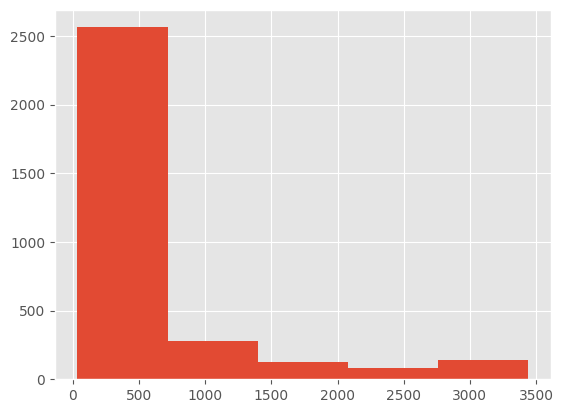

In [ ]:
plt.hist([len(s) for s in train_texts], bins=5)
plt.show()

In [ ]:
max([len(s) for s in train_texts]) # we will need truncation (automatically on token encodings and manually in the encode_labels function)

3442

In [ ]:
max([len(s) for s in test_texts])

3442

In [ ]:
max([len(s) for s in dev_texts])

3431

## Explicit Truncation

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)

In [ ]:
train_encodings = tokenizer(train_texts, padding=True, truncation=True, max_length=128)
dev_encodings = tokenizer(dev_texts, padding=True, truncation=True, max_length=128)
test_encodings = tokenizer(test_texts, padding=True, truncation=True, max_length=128)

In [ ]:
len(train_encodings[0])

128

In [ ]:
import numpy as np

# Assuming train_labels, dev_labels, and test_labels are numpy arrays containing labels
unique_classes_train = np.unique(train_labels)
unique_classes_dev = np.unique(dev_labels)
unique_classes_test = np.unique(test_labels)

num_classes_train = len(unique_classes_train)
num_classes_dev = len(unique_classes_dev)
num_classes_test = len(unique_classes_test)

print("Number of classes in training set:", num_classes_train)
print("Number of classes in development set:", num_classes_dev)
print("Number of classes in test set:", num_classes_test)

Number of classes in training set: 4
Number of classes in development set: 4
Number of classes in test set: 4


In [ ]:
unique_classes_test = np.unique(test_labels)

# Print unique classes
print("Unique classes in test set:")
for cls in unique_classes_test:
    print(cls)

Unique classes in test set:
0
1
2
3


### Dataset objects 

Create the dataset objects

In [ ]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [ ]:
train_dataset = MyDataset(train_encodings, train_labels)
dev_dataset = MyDataset(dev_encodings, dev_labels)
test_dataset = MyDataset(test_encodings, test_labels)

# Hyperparameter Optimization

## Set-up

Instantiating the model

In [ ]:
from transformers import AutoModelForSequenceClassification

def model_init():
    return AutoModelForSequenceClassification.from_pretrained(MODEL_PATH, num_labels=4)

Defining the hyperparameter search space

In [ ]:
from optuna import Trial
from typing import Dict, Union

def hp_space(trial: Trial) -> Dict[str, Union[float, int, str]]:
    return {
        "learning_rate": trial.suggest_float("learning_rate", 1e-6, 1e-3, log=True),
        "num_train_epochs": trial.suggest_int("num_train_epochs", 3, 10),
    }

Defining the compute_metrics function

In [ ]:
from sklearn.metrics import accuracy_score
# from datasets import load_metric

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=1)

    # print(labels)
    # print(predictions)
    # Remove ignored index (special tokens)
    # Create a long 1D list of y_true and y_pred
    y_true = []
    y_pred = []
    for pred, lbl in zip(predictions, labels):  
      y_true.append(lbl) 
      y_pred.append(pred)    
    acc = accuracy_score(y_true, y_pred)
    return {    # we can customize this dictionary to include Pr, Recall and F1-Score as well.
        "accuracy": acc,
    }

# label_list = [0, 1, 2, 3]
# metric = load_metric("seqeval")

# def compute_metrics(p):
#     predictions, labels = p
#     predictions = np.argmax(predictions, axis=2)

#     true_predictions = [[label_list[p] for (p, l) in zip(prediction, label) if l != -100] for prediction, label in zip(predictions, labels)]
#     true_labels = [[label_list[l] for (p, l) in zip(prediction, label) if l != -100] for prediction, label in zip(predictions, labels)]

#     results = metric.compute(predictions=true_predictions, references=true_labels)
#     return {"precision": results["overall_precision"], "recall": results["overall_recall"], "f1": results["overall_f1"], "accuracy": results["overall_accuracy"]}

Clear model directory if it hasn't been cleared yet.

In [ ]:
def delete_dir(directory_path):
    if os.path.exists(directory_path):
        try:
            # Remove the directory
            shutil.rmtree(directory_path)
            print(f"Directory '{directory_path}' removed successfully.")
        except Exception as e:
            print(f"Error removing directory '{directory_path}': {e}")
    else:
        print(f"Directory '{directory_path}' does not exist.")

delete_dir("./results")
delete_dir("./re.model")

Directory './results' does not exist.
Directory './re.model' does not exist.


In [ ]:
from transformers import TrainerCallback, TrainerState

class CleanupCallback(TrainerCallback):
    def on_train_begin(self, args, state, control, **kwargs):
        shutil.rmtree("./results", ignore_errors=True)

Defining the training arguments

In [ ]:
from transformers import Trainer, TrainingArguments
from transformers.integrations import TensorBoardCallback

training_args = TrainingArguments(
    learning_rate=2.3630300777944915e-05,
    num_train_epochs=6,
    
    output_dir='./results',          # output directory
    per_device_train_batch_size=batch_size,  # batch size per device during training
    per_device_eval_batch_size=batch_size,   # batch size for evaluation
    # gradient_checkpointing=True,
    gradient_accumulation_steps=4,
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir=logdir,            # directory for storing logs
    logging_steps=10,
    evaluation_strategy = "epoch",
    save_strategy="no",
    # metric_for_best_model="eval_loss",
    # load_best_model_at_end=True,
    report_to="tensorboard",
  )

trainer = Trainer(
    model_init=model_init,                         # the instantiated Transformers model to be trained
    tokenizer=tokenizer,
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset  
    eval_dataset=dev_dataset,           # evaluation dataset
    compute_metrics=compute_metrics,  
    callbacks=[TensorBoardCallback(), CleanupCallback()], # EarlyStoppingCallback(early_stopping_patience=3), CleanupCallback()
)

2024-03-26 20:15:47.598681: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-26 20:15:47.681252: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2024-03-26 20:15:49.339514: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/nlpbiodiv2023/ENTER/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at NoYo25/BiodivBERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You are addi

# Fine-tuning With Best Hyperparameters

In [ ]:
# torch.device("cpu")
trainer.train()
trainer.evaluate()
trainer.save_model('re.model')

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at NoYo25/BiodivBERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,1.062400,0.997456,0.685000
2,0.930700,0.878303,0.685000
3,0.814700,0.825531,0.710000
4,0.699600,0.763708,0.707500
5,0.608600,0.682824,0.730000
6,0.536600,0.669237,0.730000


# Prediction

The use of validation dataset

In [ ]:
eval_history = trainer.evaluate()

In [ ]:
predictionsOutput = trainer.predict(test_dataset) 

In [ ]:
predictionsOutput.predictions.shape

In [ ]:
predictions = predictionsOutput.predictions.argmax(axis=1)

In [ ]:
predictions.shape # each of the corresponding tokens has one label which has the highest propability

Explore one example of the test dataset (prediction vs. true) lables.

In [ ]:
for text, pred, lbl in zip(test_texts, predictions, test_labels):
  print(pred, text)
  print(lbl, text)
  break

# Evaluation Metrcies 

F1-Score, Precision and Recall, sklearn?

In [ ]:
# Create a long 1D list of y_true and y_pred
y_true = []
y_pred = []

for text, pred, lbl in zip(test_texts, predictions, test_labels):
  y_true.append(lbl)
  y_pred.append(pred)

In [ ]:
acc = accuracy_score(y_true, y_pred)
print(acc)

In [ ]:
from sklearn.metrics import precision_recall_fscore_support

In [ ]:
precision_recall_fscore_support(y_true, y_pred,labels=[0,1])

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
print(classification_report(y_true, y_pred))

In [ ]:
results = classification_report(y_true, y_pred, output_dict=True)
results

### Visualizations
Plots of learning curves (loss and accuracy) during training and validation

In [ ]:
def plot_dict(history, start_step=10,  step_size=10, use_title=None, use_xlabel=None, use_ylabel=None):
  plt.figure(figsize=(12,12))
  for key, list_val in history.items():
    plt.plot(list_val, label=key)
  plt.title(use_title)
  plt.xlabel(use_xlabel)
  plt.ylabel(use_ylabel, multialignment='center')
  plt.legend()
  plt.show()

In [ ]:
# Keep track of train and evaluate loss.
# loss_history = {'train_loss':[], 'eval_loss':[]}
loss_history = {'train_loss':[]}

# Keep track of train and evaluate accuracy
acc_history = {'train_acc':[], 'eval_acc':[]}

# Loop through each log history.
for log_history in trainer.state.log_history:

  if 'loss' in log_history.keys():
    # Deal with training/eval loss.
    loss_history['train_loss'].append(log_history['loss'])
    # loss_history['eval_loss'].append(log_history['eval_loss'])
    
  elif 'acc' in log_history.keys():
    # Deal with training/eval accuracy.
    loss_history['train_acc'].append(log_history['acc'])
    loss_history['eval_acc'].append(log_history['eval_acc'])

# Plot Losses.
plot_dict(loss_history, start_step=training_args.logging_steps, 
          step_size=training_args.logging_steps, use_title='Loss', 
          use_xlabel='Train Steps', use_ylabel='Values')

In [ ]:
eval_history